### ch03 决策树

可以通过<b>熵</b>评测哪种数据划分方式比较好, 选择信息增益(划分数据集前后信息发生的变化)最高的特征就是best，选择按每个特征划分后的熵相比原熵的增加最多的，对数据集进行划分。

通过递归的方式建立决策树，书中用的是嵌套的字典表示树。

信息熵：

$$H = - \sum{^n _{i=1} p(x)logp(x_i)}$$
#n是分类的数目，p(x)选择该分类的概率

注意在按某一种特征进行划分后要多乘概率（条件熵），详见代码

reference：
信息增益到底怎么理解呢？ - 半瓶水的回答 - 知乎
https://www.zhihu.com/question/22104055/answer/272137878

In [1]:
import math
import operator


def calchannonEnt(dataSet):
    # 计算香农熵
    # dataSet的形式为【feature，feature，label】
    nunEntries = len(dataSet)
    labelCounts = {}
    for featureVec in dataSet:
        currentLabel = featureVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / nunEntries
        shannonEnt -= prob * math.log(prob, 2)
    return  shannonEnt

def createDataSet():
    """
    第一列的1表示的是不需要浮出水面就可以生存的，0则表示相反。 第二列同样是1表示有脚蹼，0表示的是没有。yes鱼类，no非鱼类
    :return:
    """
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return  dataSet, labels


In [2]:
myDat, labels = createDataSet()
print(myDat)
calchannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


0.9709505944546686

In [3]:
def splitDataSet(dataSet, axis ,value):
    #根据第axis个特征是否等于value，划分数据集dataSet,
    retDataSet = []
    for featureVec in dataSet:
        if featureVec[axis] == value:
            reducedFeatVec = featureVec[:axis]
            reducedFeatVec.extend(featureVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def bestFeatureToSplit(dataSet):
    #选择信息增益最高的特征就是best,返回一个样本中的特征索引
    #计算初始熵
    baseEntropy = calchannonEnt(dataSet)
    numFeatures = len(dataSet[0]) - 1
    maxInfoGain = 0.0
    bestFeatureidx = -1
    for i in range(numFeatures):
        #对每一个feature
        featureValueList = [example[i] for example in dataSet]
        uniqueValues = set(featureValueList) #set中的值互不相同
        newEntropy = 0.0
        for value in uniqueValues:
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calchannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        # print("i=%d  ,infogain= %f" %(i,newEntropy))
        if (infoGain > maxInfoGain):
            maxInfoGain = infoGain
            bestFeatureidx = i
    return bestFeatureidx


In [4]:
print(bestFeatureToSplit(myDat))


0


使用嵌套字典来表示树，
构造过程如下：

```

s={'no sur':{}}   
s['no sur'][0]='no'


```

In [5]:

def majorCnt(classlist):
    # 返回出现次数最多的key
    classCount = {}
    for vote in classlist:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedclassCount = sorted(classCount.items(), key = lambda x:x[1], reverse = True)
    return sortedclassCount[0][0]


def createTree(dataSet, labels):
    #label为特征，dataset【featurevalue，...，label】
    classList = [example[-1] for example in dataSet]#所有样本的label
    if classList.count(classList[0]) == len(classList):
        #list.count(obj)统计obj出现的次数
        return classList[0] # dataSet的类别完全相同，停止划分,返回该label
    if len(dataSet[0]) == 1:
        #遍历完所有特征，dataset中只剩【label】，
        #但仍然不能将数据集划分成仅包含唯一类别分组 则返回出现次数最多的label
        return majorCnt(classList)

    bestFeatureidx = bestFeatureToSplit(dataSet)
    bestFeatureLabel = labels[bestFeatureidx]

    myTree = {bestFeatureLabel:{}} # 用字典的嵌套来表示树
    del(labels[bestFeatureidx]) #del()删除, 已使用bestFeature，不再需要
    featureValues = [example[bestFeatureidx] for example in dataSet]
    # print(featureValues)
    uniqueValues = set(featureValues)#确定好特征后，按照feature values进行分类
    for value in uniqueValues:
        subLabels = labels[:]
        subDataSet = splitDataSet(dataSet, bestFeatureidx, value)
        myTree[bestFeatureLabel][value] = createTree(subDataSet,subLabels)
    return myTree


In [6]:
import treePlotter
%matplotlib inline 
#jupyter中需要使用这个命令才能显示图片


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


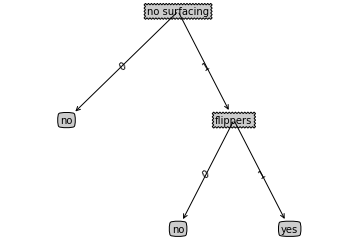

In [7]:
import treePlotter

myDat, labels = createDataSet()
mytree = createTree(myDat, labels)
print(mytree)
# print(treePlotter.getNumLeafs(mytree))
# print(treePlotter.getTreeDepth(mytree))
treePlotter.createPlot(mytree)

In [8]:

def classify(inputTree, featureLabel, testVector):
    # 找到最终的叶子结点
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featureidx = featureLabel.index(firstStr) #index(obj),返回obj的索引值
    for key in secondDict.keys():
        if key == testVector[featureidx]:
            if  type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[testVector[featureidx]], featureLabel, testVector)
            else:
                classLabel = secondDict[testVector[featureidx]]
    return classLabel


In [9]:
myDat, labels = createDataSet()
print(myDat)
mytree = createTree(myDat, labels)
print(mytree)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [10]:
def storeTree(inputTree, filename):
    # 存储决策树，方便调用
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [11]:
storeTree(mytree, 'myDecisionTree.txt')
fr = grabTree('myDecisionTree.txt')
# treePlotter.createPlot()
print(fr)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


### 使用决策树对隐形眼镜数据集进行分类

['age', 'prescript', 'astigmatic', 'tearRate']


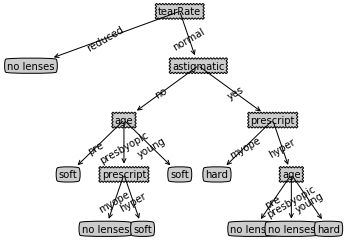

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'young': 'soft'}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'pre': 'no lenses', 'presbyopic': 'no lenses', 'young': 'hard'}}}}}}}}


In [12]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]

lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesLabelscopy = lensesLabels.copy()
lensesTree = createTree(lenses, lensesLabelscopy)
print(lensesLabels)
treePlotter.createPlot(lensesTree)
print(lensesTree)